In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# let's see how our images look like
train_path = 'Coronahack-Chest-XRay-Dataset/train/'
test_path = 'Coronahack-Chest-XRay-Dataset/test/'

In [3]:
from torchvision import datasets, models, transforms

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 0.1)),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(),
    transforms.RandomVerticalFlip(),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(226),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:622: UserWarning: range should be of kind (min, max)
  warnings.warn("range should be of kind (min, max)")


(1482, 1989, 3)


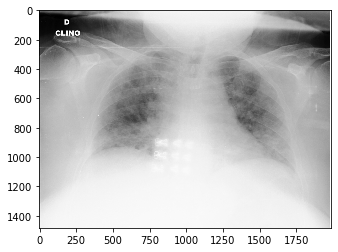

In [7]:
import os
f = os.listdir(train_path + '1/')[0]
img = cv2.imread(train_path + '1/' + f, cv2.IMREAD_COLOR)
print(img.shape)
plt.imshow(img)
plt.show()

In [27]:
train_data = datasets.ImageFolder(train_path, transform=train_transforms)
test_data = datasets.ImageFolder(test_path, transform=test_transforms)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [28]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

In [5]:
# data loading is taking a while in train_loader
# let's get the data using cv2
classes = {0: '0', 1: '1'}

train_data = []
test_data = []

In [8]:
from tqdm import tqdm

for each_class in classes:
    for f in tqdm(os.listdir(train_path + classes[each_class]), position=0, leave=True):
        file_path = train_path + classes[each_class] + f'/{f}'
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (100, 100))
        train_data.append([img, each_class])
        

for each_class in classes:
    for f in tqdm(os.listdir(test_path + classes[each_class]), position=0, leave=True):
        file_path = test_path + classes[each_class] + f'/{f}'
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (100, 100))
        test_data.append([img, each_class])

train_data = np.array(train_data)
test_data = np.array(test_data)

100%|██████████████████████████████████████████████████| 390/390 [00:06<00:00, 62.20it/s]


In [9]:
np.random.shuffle(train_data)
np.random.shuffle(test_data)

In [10]:
train_X = torch.Tensor([i[0] for i in train_data]).view(-1, 100, 100)
train_X = train_X / 255.0
train_y = torch.Tensor([i[1] for i in train_data])

test_X = torch.Tensor([i[0] for i in test_data]).view(-1, 100, 100)
test_y = torch.Tensor([i[1] for i in test_data])

In [11]:
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

torch.Size([5286, 100, 100]) torch.Size([5286])
torch.Size([624, 100, 100]) torch.Size([624])


In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.conv5 = nn.Conv2d(128, 64, 3)
        
        self.linear_shape = None
        self.convs(torch.rand(100, 100).view(-1, 1, 100, 100))
        
        self.classifier = nn.Sequential(
            nn.Linear(self.linear_shape, 1024),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
#         self.fc1 = nn.Linear(self.linear_shape, 1024)
#         self.fc2 = nn.Linear(1024, 256)
#         self.fc3 = nn.Linear(256, 1)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv5(x)), (2, 2))
        
        if self.linear_shape is None:
            self.linear_shape = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self.linear_shape)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         x = torch.sigmoid(x)
        x = self.classifier(x)
        return x

In [13]:
net = Net()
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=1024, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [14]:
optimizer = optim.Adam(net.parameters(), lr=0.003)
criterion = nn.BCELoss()

In [15]:
from tqdm import tqdm
EPOCHS = 10
BATCH_SIZE=64

total_loss = []
epoch_losses = []

for epoch in range(EPOCHS):
    
    val_off = int(0.1 * len(train_X))
    X = train_X[:-val_off]
    y = train_y[:-val_off]
    
    valid_X = train_X[-val_off:]
    valid_y = train_y[-val_off:]
    
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    epoch_loss = []
    for i in tqdm(range(0, len(X), BATCH_SIZE), position=0, leave=True):
        
        optimizer.zero_grad()
        
        batch_X = X[i:i+BATCH_SIZE].view(-1, 1, 100, 100)
        batch_y = y[i:i+BATCH_SIZE]
        
        out = net(batch_X)
        loss = criterion(out.view(-1).float(), batch_y.float())
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    
    with torch.no_grad():
        valid_loss = criterion(net(valid_X.view(-1, 1, 100, 100)).view(-1).float(), valid_y.float())
        epoch_losses.append([loss.item(), valid_loss.item()])
    total_loss.append(epoch_loss)
    print(f'Epoch Loss:- Training Loss: {loss.item()}, Validation Loss: {valid_loss.item()}')

  0%|                                                             | 0/75 [00:00<?, ?it/s]

Epoch 1/10


  0%|                                                             | 0/75 [00:00<?, ?it/s]

Epoch Loss:- Training Loss: 0.29636016488075256, Validation Loss: 0.2735655605792999
Epoch 2/10


  0%|                                                             | 0/75 [00:00<?, ?it/s]

Epoch Loss:- Training Loss: 0.15186910331249237, Validation Loss: 0.2102428525686264
Epoch 3/10


  0%|                                                             | 0/75 [00:00<?, ?it/s]

Epoch Loss:- Training Loss: 0.16666947305202484, Validation Loss: 0.11330467462539673
Epoch 4/10


  0%|                                                             | 0/75 [00:00<?, ?it/s]

Epoch Loss:- Training Loss: 0.14768065512180328, Validation Loss: 0.09796778857707977
Epoch 5/10


  0%|                                                             | 0/75 [00:00<?, ?it/s]

Epoch Loss:- Training Loss: 0.1081710085272789, Validation Loss: 0.09183812141418457
Epoch 6/10


  0%|                                                             | 0/75 [00:00<?, ?it/s]

Epoch Loss:- Training Loss: 0.038608428090810776, Validation Loss: 0.09074472635984421
Epoch 7/10


  0%|                                                             | 0/75 [00:00<?, ?it/s]

Epoch Loss:- Training Loss: 0.007668263744562864, Validation Loss: 0.13538284599781036
Epoch 8/10


  0%|                                                             | 0/75 [00:00<?, ?it/s]

Epoch Loss:- Training Loss: 0.012326986528933048, Validation Loss: 0.08105818927288055
Epoch 9/10


  0%|                                                             | 0/75 [00:00<?, ?it/s]

Epoch Loss:- Training Loss: 0.05263418331742287, Validation Loss: 0.1111067607998848
Epoch 10/10


100%|████████████████████████████████████████████████████| 75/75 [01:21<00:00,  1.09s/it]


Epoch Loss:- Training Loss: 0.005715482402592897, Validation Loss: 0.10537966340780258


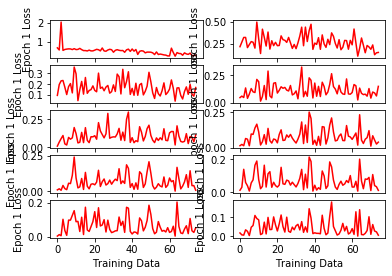

In [16]:
for i in range(EPOCHS):
    plt.subplot(EPOCHS // 2, 2, i + 1)
    plt.plot(total_loss[i], 'r')
    plt.xlabel('Training Data')
    plt.ylabel('Epoch 1 Loss')

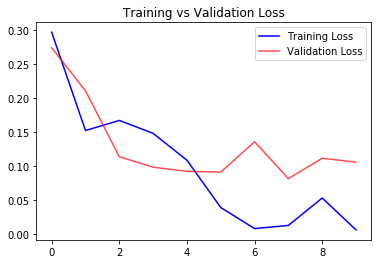

In [17]:
plt.plot(np.array(epoch_losses)[:, 0], 'b', label='Training Loss')
plt.plot(np.array(epoch_losses)[:, 1], 'r', label='Validation Loss', alpha=0.7)
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [29]:
# testing on test set
correct = 0
total = 0

for i in range(0, len(test_X), BATCH_SIZE):
    batch_X = test_X[i:i+BATCH_SIZE].view(-1, 1, 100, 100)
    batch_y = test_y[i:i+BATCH_SIZE]
    
    with torch.no_grad():
        out = net(batch_X).view(-1)
        out = np.array(list(map(int, out >= 0.8)))
        batch_y = np.array(list(map(int, batch_y)))
        total += len(out)
        correct += sum(list(map(int, out == batch_y)))
        
print(f'Testing Accuracy {round(correct/total, 4) * 100}%')

Testing Accuracy 72.92%
